# HRF downsampling
This short notebook is why (often) we have to downsample our predictors after convolution with an HRF.

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nistats.hemodynamic_models import glover_hrf
%matplotlib inline

First, let's define our data. Suppose we did an experiment where we show subjects images for 4 seconds. The onset of the stimuli we're drawn semi-randomly: every 15 seconds but +/- 3 to 5 seconds. In total, the experiment lasted 5 minutes. The fMRI data we acquired during the experiment had a TR of 2 seconds.

In [27]:
TR = 2  # seconds
time_exp = 5*60  # seconds
number_of_events = 10
duration_of_events = 4
onsets_sec = np.arange(0, time_exp, 15) + np.random.uniform(3, 5, 20)
onsets_sec = np.round(onsets_sec, 3)
print("Onset events: %s" % (onsets_sec,))

Onset events: [  4.404  18.533  33.223  48.438  64.592  78.842  94.015 109.126 123.067
 138.108 154.15  169.913 184.614 199.094 213.121 229.443 243.457 259.559
 274.793 289.33 ]


As you can see, the onsets are not neatly synchronized to the time that we acquired the different volumes of our fMRI data, which are (with a TR of 2): `[0, 2, 4, 6, ..., 298]` seconds. In other words, the data (onsets) of our experimental paradigm are on a different scale (i.e., with a precision of milliseconds) than our fMRI data (i.e., with a precision/temporal resolution of 2 seconds)! 

So, what should we do? One thing we *could* do, is to round each onset to the nearest TR. So, we'll pretend that for example an onset at 2.9 seconds happened at 2 seconds. This, however, is of course not very precise and, fortunately, not necessary. Another, and better, option is to create your design and convolve your regressors with an HRF at the time scale and temporal resolution of your onsets and *then*, as a last step, downsample your regressors to the temporal resolution of your fMRI data (which is defined by your TR).

So, given that our onsets have been measured on a millisecond scale, let's create our design with this temporal resolution. First, we'll create an empty stimulus-vector with a length of the time of the experiment in seconds times 1000 (because we want it in milliseconds):

In [21]:
stim_vector = np.zeros(time_exp * 1000)
print("Length of stim vector: %i" % stim_vector.size)

Length of stim vector: 300000


Now, let's convert our onsets to milliseconds:

In [22]:
onsets_msec = onsets_sec * 1000

Now we can define within our `stim_vector` when each onset happened. Importantly, let's assume that each stimulus lasted 4 seconds.

In [29]:
for onset in onsets_msec:
    onset = int(onset)
    stim_vector[onset:(onset+duration_of_events*1000)] = 1

Alright, let's plot it:

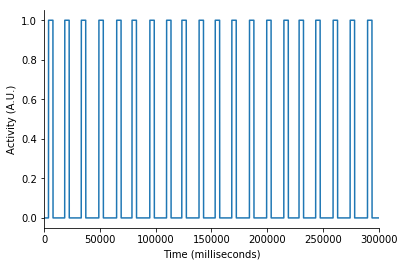

In [38]:
plt.plot(stim_vector)
plt.xlim(0, time_exp*1000)
plt.xlabel('Time (milliseconds)')
plt.ylabel('Activity (A.U.)')
sns.despine()
plt.show()

Sweet, now let's define an HRF:

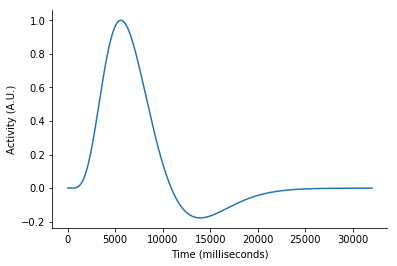

In [47]:
hrf = glover_hrf(tr=TR, time_length=32, oversampling=TR*1000)
hrf = hrf / hrf.max()

plt.plot(hrf)
plt.xlabel('Time (milliseconds)')
plt.ylabel('Activity (A.U.)')
sns.despine()
plt.show()

Let's convolve!

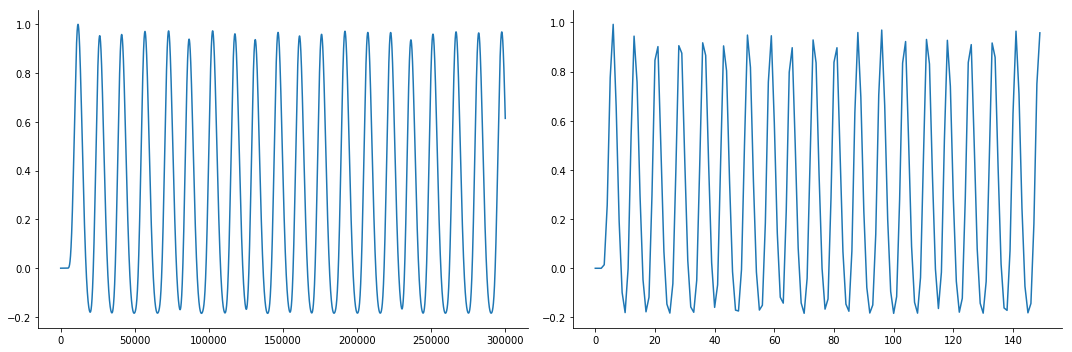

In [56]:
conv = np.convolve(stim_vector, hrf)[:stim_vector.size]
conv = conv / conv.max()

conv_ds = conv[::TR*1000]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(conv)

plt.subplot(1, 2, 2)
plt.plot(conv_ds)
plt.tight_layout()
sns.despine()
plt.show()